In [ ]:
    """
    #Go to anadoconda promt and give the commands

    conda create -n py310 python=3.10
    conda active py310
    conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
    python -m pip install "tensorflow<2.11" "numpy<2.0" opencv-python matplotlib scikit-learn pandas seaborn

    #After that select the py310 kernal for executing the code
    #if you have conda setted up first then just execute this cell, that will be enough
    """
    !python -m pip install "tensorflow<2.11" "numpy<2.0" opencv-python matplotlib scikit-learn pandas seaborn xgboost lightgbm

In [ ]:
# Clear all variables in the current session
# Only run this if you want to delete all run time variable from this kernel
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [1]:
# %% Import Libraries

# Standard Libraries
import os
import shutil
import random

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Flatten, GlobalMaxPooling2D, Concatenate,
    Multiply, Reshape
)
from tensorflow.keras.optimizers import Adam

# Predefined CNN Models
from tensorflow.keras.applications import (
    VGG16, VGG19,
    ResNet50, ResNet101, ResNet152,
    ResNet50V2, ResNet101V2, ResNet152V2,
    InceptionV3, InceptionResNetV2,
    DenseNet121, DenseNet169, DenseNet201,
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
    MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
    NASNetMobile, NASNetLarge,
    Xception
)

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# Machine Learning Classifiers
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, 
    ExtraTreesClassifier, VotingClassifier, StackingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Google Drive Integration if you use colab
#from google.colab import drive

# File Handling
import zipfile

> This porton of code detects any available GPU and set its memory growth equals "True" so that the process will take only necessary amount of memory in GPU and won't take every bit of available memory and prevent out of memory error

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPUs detected.")

No GPUs detected.


> This will mount google drive account with this python notebook

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


> This will copy the dataset zip file path from drive to colab environment and then unzip the file in colab disk  

In [ ]:
import zipfile

# Step 2: Define the path to your .zip file in Google Drive
drive_zip_path = '/content/drive/MyDrive/Dataset/blood-cancer.zip'  # Replace with the actual path to your .zip file in Drive
colab_zip_path = '/content/blood-cancer.zip'  # Destination path in Colab environment

# Step 3: Copy the .zip file from Google Drive to Colab environment
shutil.copy(drive_zip_path, colab_zip_path)

# Step 4: Unzip the file in Colab environment
extracted_path = '/content'  # Destination folder for unzipped content
os.makedirs(extracted_path, exist_ok=True)

with zipfile.ZipFile(colab_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Dataset successfully extracted to: {extracted_path}")

Dataset successfully extracted to: /content
Contents of the extracted folder:
['.config', 'blood-cancer.zip', 'blood Cancer', 'drive', 'sample_data']


> Here the image dataset path is provided along with img size and batch size and others global variables 

In [3]:
dataset_path = "normalized_output of Blood Cancer vahadane"

classes= ["all_benign", "all_early", "all_pre", "all_pro"]
# Global variable for batch size
BATCH_SIZE = 32

# Define dataset paths
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

# Image size and number of classes
img_size = (224, 224)
num_classes = 4  # For Binary classification use 1

> Get a feature extraction model dynamically based on the given model name.

* Parameters:
    * model_name (str): The name of the model. It should match one of the models in `tensorflow.keras.applications`.
    * input_shape (tuple): The input shape for the model.

* Returns:
    * Model: A Keras Model configured for feature extraction.


In [4]:
#Get feature extractor function
def get_feature_extractor(model_name, input_shape=(224, 224, 3)):
    
    if model_name == "VGG16":
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "VGG19":
        base_model = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "ResNet101":
        base_model = ResNet101(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "ResNet152":
        base_model = ResNet152(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "ResNet50V2":
        base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "ResNet101V2":
        base_model = ResNet101V2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "ResNet152V2":
        base_model = ResNet152V2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "InceptionResNetV2":
        base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "DenseNet121":
        base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "DenseNet169":
        base_model = DenseNet169(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "DenseNet201":
        base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB0":
        base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB1":
        base_model = EfficientNetB1(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB2":
        base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB3":
        base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB4":
        base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB5":
        base_model = EfficientNetB5(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB6":
        base_model = EfficientNetB6(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB7":
        base_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "MobileNet":
        base_model = MobileNet(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "MobileNetV2":
        base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "MobileNetV3Small":
        base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "MobileNetV3Large":
        base_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "NASNetMobile":
        base_model = NASNetMobile(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "NASNetLarge":
        base_model = NASNetLarge(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "Xception":
        base_model = Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Model '{model_name}' is not available in tensorflow.keras.applications. Check the spelling or ensure the model is supported.")

    # Add a global average pooling layer for feature extraction
    gap = GlobalAveragePooling2D()(base_model.output)
    se = Dense(base_model.output_shape[-1] // 16, activation="relu")(gap)
    se = Dense(base_model.output_shape[-1], activation="sigmoid")(se)
    se = Reshape((1, 1, -1))(se)
    x = Multiply()([base_model.output, se])
    x = GlobalAveragePooling2D()(x)  # Final feature extraction
    feature_extractor = Model(inputs=base_model.input, outputs=x)

    return feature_extractor

> This will define the train data and test data generator for batch wise feature extraction from photos

In [5]:
# Load dataset
class_mode = 'binary' if num_classes == 1 else 'categorical'
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_dataset = datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=BATCH_SIZE, class_mode=class_mode, classes= classes,  shuffle=False
)
test_dataset = datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=BATCH_SIZE, class_mode=class_mode, classes=classes, shuffle=False
)

Found 18000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


> This function saves CNN features and corresponding labels incrementally to an HDF5 file. It processes the dataset in batches, extracts features using a given model, and appends them to the file. Supports compression and alignment checks, and prints progress every 50 steps and also freeup the memory after processing every batch.

In [6]:
# Function to save features incrementally
def save_cnn_features_and_labels_incrementally_to_h5(dataset, model, filename, steps):
    with h5py.File(filename, 'a') as f:
        for step, (batch, labels) in enumerate(dataset):
            if step >= steps:  # Stop after the specified number of steps
                break
            #indicator after every 50 steps complete
            if step % 50 == 0:
                print(f"Processing batch {step}-{min(step + 50, steps)}/{steps}")
            # Extract features
            features = model.predict(batch, verbose=0)

            # Ensure alignment between features and labels
            assert features.shape[0] == labels.shape[0], (
                f"Mismatch in features ({features.shape[0]}) and labels ({labels.shape[0]}) sizes"
            )

            if step == 0:  # First batch
                # Determine maxshape for features and labels
                feature_maxshape = (None, *features.shape[1:])  # Features can have more dimensions
                label_maxshape = (None,) if len(labels.shape) == 1 else (None, *labels.shape[1:])

                # Create datasets if they don't exist
                if 'features' not in f:
                    f.create_dataset('features', data=features, maxshape=feature_maxshape, compression='lzf')
                if 'labels' not in f:
                    f.create_dataset('labels', data=labels, maxshape=label_maxshape, compression='lzf')
            else:
                # Resize and append to existing datasets
                if 'features' in f and 'labels' in f:
                    f['features'].resize((f['features'].shape[0] + features.shape[0]), axis=0)
                    f['features'][-features.shape[0]:] = features

                    f['labels'].resize((f['labels'].shape[0] + labels.shape[0]), axis=0)
                    f['labels'][-labels.shape[0]:] = labels
                else:
                    raise KeyError("Features or labels datasets are missing in the HDF5 file.")

            # Memory cleanup
            del features, labels, batch
            tf.keras.backend.clear_session()

    print(f"Features and labels saved to {filename}")

> Input any cnn model name to get the model for feature extraction 

In [7]:
cnn_model = get_feature_extractor("VGG16", input_shape=(224, 224, 3))

> defining the feature saving location in disk and storing features along with calculation of total steps(batch) required for completing the task

In [ ]:
# Calculate steps
train_steps = int(np.ceil(train_dataset.n / BATCH_SIZE))
test_steps = int(np.ceil(test_dataset.n / BATCH_SIZE))

#location for saving file
save_train_location = "Vahadane Features/train_features_VGG16.h5"
save_test_location =  "Vahadane Features/test_features_VGG16.h5"

# Save features for test and train
save_cnn_features_and_labels_incrementally_to_h5(train_dataset, cnn_model, save_train_location, train_steps)
save_cnn_features_and_labels_incrementally_to_h5(test_dataset, cnn_model, save_test_location, test_steps)

> This function evaluates the performance of a model by calculating accuracy, precision, recall, and F1 score based on predictions on the test set. It also displays the confusion matrix and returns the performance metrics in a dictionary.


In [5]:
# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a single model and return performance metrics.
    """
    # Predict labels
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary" if len(np.unique(y_test)) == 2 else "weighted")
    recall = recall_score(y_test, y_pred, average="binary" if len(np.unique(y_test)) == 2 else "weighted")
    f1 = f1_score(y_test, y_pred, average="binary" if len(np.unique(y_test)) == 2 else "weighted")

    # Print metrics
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

> this function takes aa dictionary of models, train and test data and evaluates all of them

In [6]:
# Function to evaluate multiple models
def evaluate_all_models(models, X_test, y_test):
    """
    Evaluate multiple models and return a summary of metrics.
    """
    results = []

    for model_name, model in models.items():
        try:
            metrics = evaluate_model(model, X_test, y_test, model_name)
            results.append(metrics)
        except Exception as e:
            print(f"Error while evaluating {model_name}: {e}")
            results.append({model_name: "Error during evaluation"})  

    return results


> This functions load the image features that is saved on the device

In [5]:
# Example models and data loading (replace with your dataset and trained models)
def load_features_and_labels(filename):
    """
    Load features and labels from an .h5 file.
    """
    with h5py.File(filename, "r") as f:
        print(f"Features dataset shape: {f['features'].shape}")
        print(f"Labels dataset shape: {f['labels'].shape}")
        X = np.array(f["features"])
        y = np.array(f["labels"])
    return X, y

In [6]:
# Load test dataset with appropriate location
train_features_file = "Features/Vahadane Features/train_features_VGG16.h5"
test_features_file = "Features/Vahadane Features/test_features_VGG16.h5"

X_train, y_train = load_features_and_labels(train_features_file)
X_test, y_test = load_features_and_labels(test_features_file)

# Convert labels to 1D
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

Features dataset shape: (18000, 512)
Labels dataset shape: (18000, 4)
Features dataset shape: (2000, 512)
Labels dataset shape: (2000, 4)


> detele from here

> Defining ML models for classifing the cancer

In [7]:
# Define individual models
knn = KNeighborsClassifier(n_neighbors=10)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel="linear", probability=True)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
logreg = LogisticRegression(max_iter=1000, random_state=42)
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
nb = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, force_col_wise=True )
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)

# Stacking Classifier (Logistic Regression as the meta-classifier)
stacking = StackingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('mlp', mlp),
    ('lgbm', lgbm),
], final_estimator=LogisticRegression(random_state=42))

> Trains all models here

In [ ]:
import pickle
with open("stacking_model.pkl", "wb") as file:
    pickle.dump(stacking, file)

In [ ]:
# List of models to train
models = {
    "knn": knn,
    "rf": rf,
    "svm": svm,
    "gb": gb,
    "logreg": logreg,
    "dt": dt,
    "nb": nb,
    "mlp": mlp,
    "xgb": xgb,
    "lgbm": lgbm,
    "et": et,
    "adaboost": adaboost,
    "stacking": stacking
}

# Train each model
for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        print(f"{name} trained successfully.")
    except Exception as e:
        print(f"Error while training {name}: {e}")

Training stacking...


c:\Users\Faysal Ahmmed\.conda\envs\py310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Faysal Ahmmed\.conda\envs\py310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Faysal Ahmmed\.conda\envs\py310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Faysal Ahmmed\.conda\envs\py310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Faysal Ahmmed\.conda\envs\py310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winap

[LightGBM] [Info] Total Bins 124306
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 506
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


> Evaluating and printing confusion matrix here

--- knn ---
Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
F1 Score: 0.9975



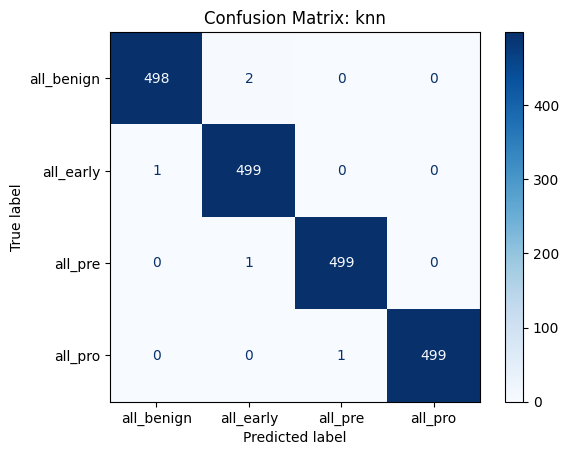

--- rf ---
Accuracy: 0.9900
Precision: 0.9900
Recall: 0.9900
F1 Score: 0.9900



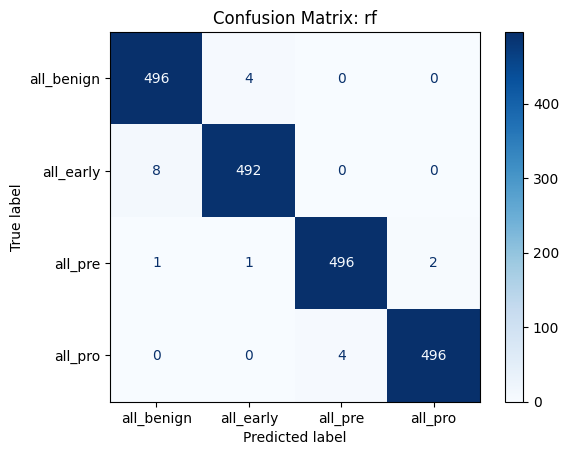

--- svm ---
Accuracy: 0.9930
Precision: 0.9930
Recall: 0.9930
F1 Score: 0.9930



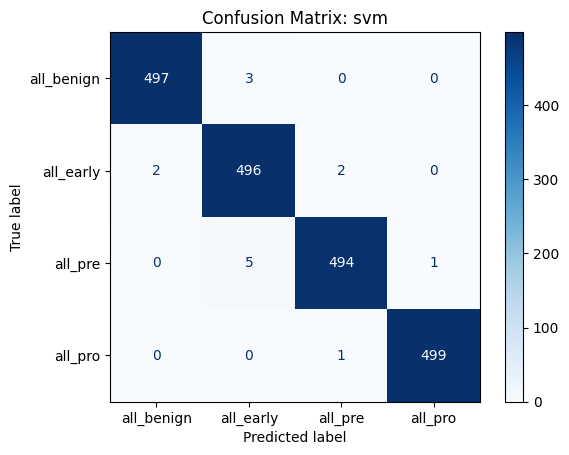

--- gb ---
Accuracy: 0.9915
Precision: 0.9915
Recall: 0.9915
F1 Score: 0.9915



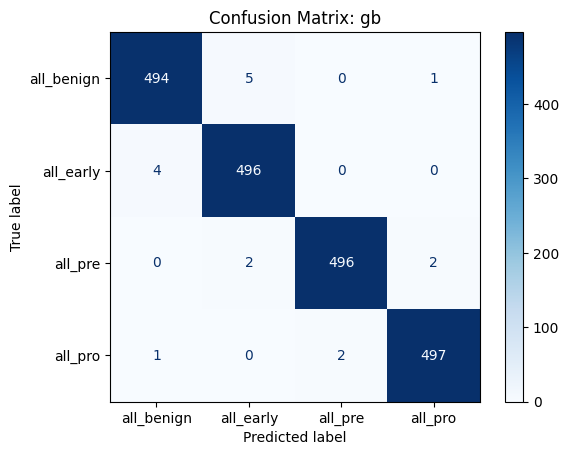

--- logreg ---
Accuracy: 0.9880
Precision: 0.9880
Recall: 0.9880
F1 Score: 0.9880



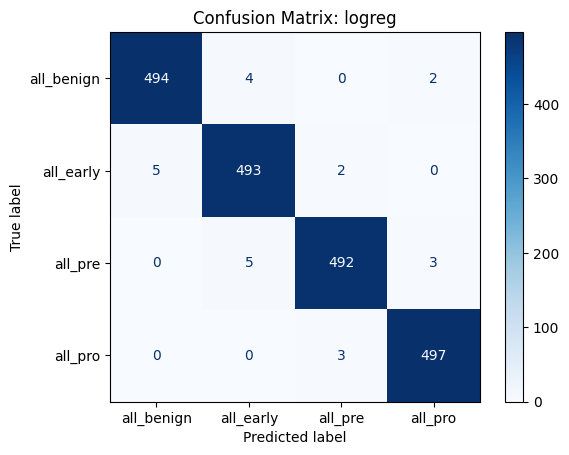

--- dt ---
Accuracy: 0.9370
Precision: 0.9371
Recall: 0.9370
F1 Score: 0.9370



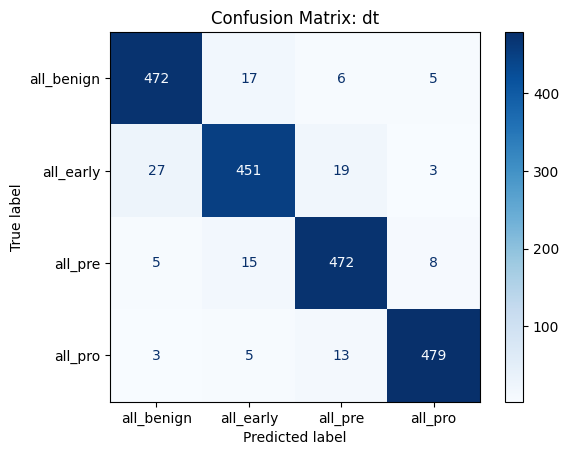

--- nb ---
Accuracy: 0.8850
Precision: 0.8863
Recall: 0.8850
F1 Score: 0.8854



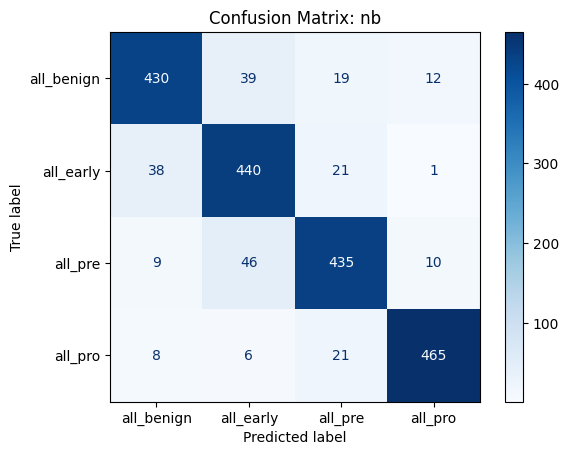

--- mlp ---
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F1 Score: 0.9990



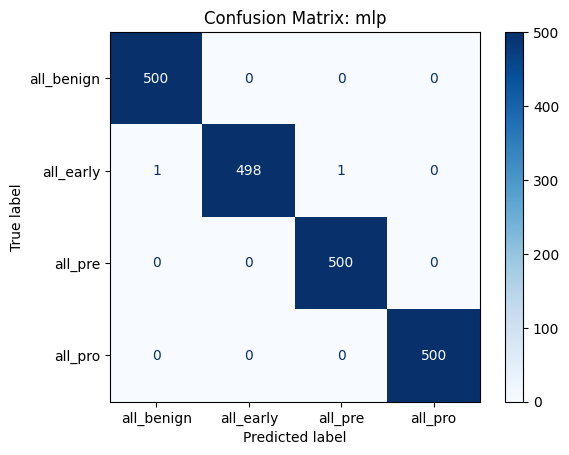

--- xgb ---
Accuracy: 0.9945
Precision: 0.9945
Recall: 0.9945
F1 Score: 0.9945



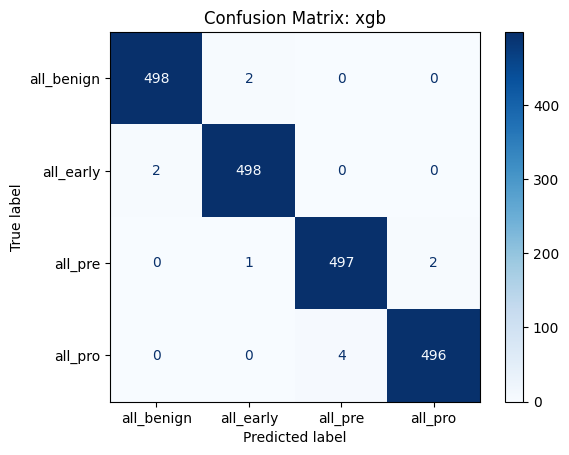

--- lgbm ---
Accuracy: 0.9970
Precision: 0.9970
Recall: 0.9970
F1 Score: 0.9970



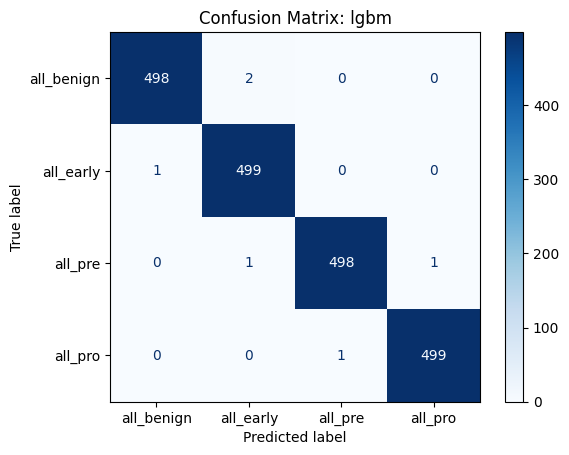

--- et ---
Accuracy: 0.9925
Precision: 0.9925
Recall: 0.9925
F1 Score: 0.9925



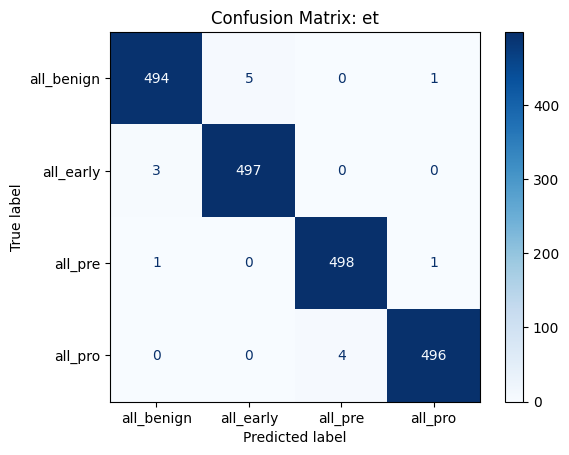

--- adaboost ---
Accuracy: 0.9115
Precision: 0.9157
Recall: 0.9115
F1 Score: 0.9113



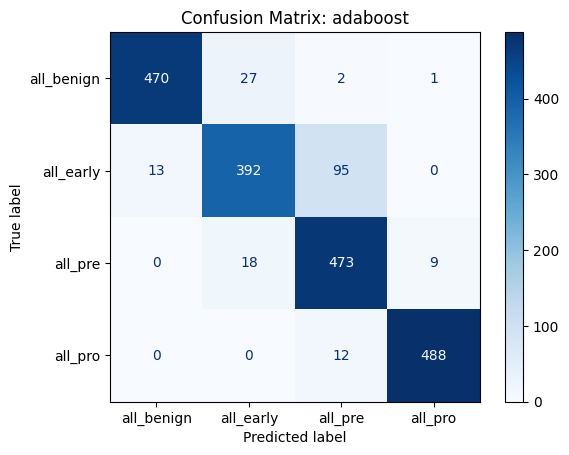

--- stacking ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F1 Score: 0.9995



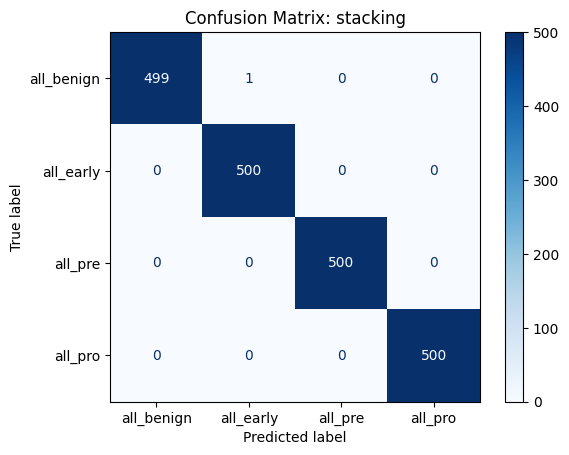


Summary of Model Performance:
   model_name  accuracy  precision  recall  f1_score
12   stacking    0.9995   0.999501  0.9995  0.999500
7         mlp    0.9990   0.999002  0.9990  0.998999
0         knn    0.9975   0.997505  0.9975  0.997501
9        lgbm    0.9970   0.997004  0.9970  0.997000
8         xgb    0.9945   0.994503  0.9945  0.994500
2         svm    0.9930   0.993021  0.9930  0.993004
10         et    0.9925   0.992506  0.9925  0.992499
3          gb    0.9915   0.991512  0.9915  0.991502
1          rf    0.9900   0.990025  0.9900  0.990003
4      logreg    0.9880   0.988008  0.9880  0.987999
5          dt    0.9370   0.937078  0.9370  0.936965
11   adaboost    0.9115   0.915686  0.9115  0.911308
6          nb    0.8850   0.886277  0.8850  0.885357


In [10]:
# Evaluate all models
results = evaluate_all_models(models, X_test, y_test)

# Summarize results
summary_df = pd.DataFrame(results)
print("\nSummary of Model Performance:")
print(summary_df.sort_values(by="accuracy", ascending=False))